<a href="https://colab.research.google.com/github/justprophet/Memorability-of-videos/blob/master/code/Memorability_with_Captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spearman Coefficient

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

# Mounting the drive

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Semester 2/Machine Learning/Assignment/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install pyprind

# Importing Libraries

In [4]:
import pandas as pd
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
# Import EarlyStopping
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download()
nltk.download('punkt')

import numpy as np
import pyprind
plotlib.pyplot as plt

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

# Load Captions and Video Memorability from the two files

In [0]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path = './dev-set_video-captions.txt'
df_captions=read_caps(cap_path)

# load the ground truth values
label_path = './'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

Joining the dataframes.

In [7]:
df = df_captions.merge(labels,on=["video"],how="inner")
df.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12
2,video6.webm,khr-gangsters,0.863,33,0.700,10
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10


# Tokenizing Words in Captions

In [8]:
df['caption'].apply(nltk.word_tokenize)
df['caption'].head()

0                   blonde-woman-is-massaged-tilt-down
1    roulette-table-spinning-with-ball-in-closeup-shot
2                                        khr-gangsters
3                 medical-helicopter-hovers-at-airport
4                 couple-relaxing-on-picnic-crane-shot
Name: caption, dtype: object

#Stemming words 

In [0]:
porter = PorterStemmer()
lancaster=LancasterStemmer()

In [0]:
#porter.stem(df['caption'])
def stem_sentences(sentence):
    tokens = sentence.split()
    #stemmed_tokens = [porter.stem(token) for token in tokens]
    stemmed_tokens = [lancaster.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)
  
df['caption'] = df['caption'].apply(stem_sentences)  

#Using Count Vecorizer

In [0]:
cv=CountVectorizer(ngram_range=(1, 2))

In [0]:
X_CV=cv.fit_transform(df['caption'])

In [13]:
type(X_CV)

scipy.sparse.csr.csr_matrix

In [14]:
X_arrseq=X_CV.toarray()
X_arrseq

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
print(X_arrseq[0])

[0 0 0 ... 0 0 0]


# Splitting the Data in Train and Test

In [0]:
Y=df[['short-term_memorability','long-term_memorability']].values  #targets
X=X_arrseq #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

In [18]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 25937)
X_test (1200, 25937)
Y_train (4800, 2)
Y_test (1200, 2)


# Construction of Neural Networks

In [19]:
n_cols = X_train.shape[1]
n_cols

25937

In [0]:
# Save the number of columns in predictors: n_cols


# Set up the model: model
model = Sequential()

In [21]:
# Add the first layer
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Add the second layer
model.add(Dense(100, activation='relu'))

In [0]:
# Add the output layer
model.add(Dense(2))

#Changing optimization parameters

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)
    
# Fit the model
#model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))
# Fit the model
history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

Instructions for updating:
Use tf.cast instead.
Train on 3360 samples, validate on 1440 samples
Epoch 1/30
3360/3360 [==============================] - 5s 2ms/step - loss: 0.1125 - acc: 0.6702 - val_loss: 0.0318 - val_acc: 0.6875
Epoch 2/30
3360/3360 [==============================] - 5s 1ms/step - loss: 0.0241 - acc: 0.7464 - val_loss: 0.0173 - val_acc: 0.6813
Epoch 3/30
3360/3360 [==============================] - 5s 1ms/step - loss: 0.0076 - acc: 0.8086 - val_loss: 0.0166 - val_acc: 0.6618
Epoch 4/30
3360/3360 [==============================] - 5s 1ms/step - loss: 0.0043 - acc: 0.8586 - val_loss: 0.0165 - val_acc: 0.6764
Epoch 5/30
3360/3360 [==============================] - 5s 1ms/step - loss: 0.0036 - acc: 0.8616 - val_loss: 0.0168 - val_acc: 0.6569
Epoch 6/30
3360/3360 [==============================] - 5s 2ms/step - loss: 0.0033 - acc: 0.8649 - val_loss: 0.0165 - val_acc: 0.6389
Epoch 7/30
3360/3360 [==============================] - 5s 2ms/step - loss: 0.0030 - acc: 0.8810 - v

In [0]:
# Compile the model
#model.compile(optimizer='adam', loss = 'mean_squared_error')

In [0]:
# Verify that model contains information from compiling
#print("Loss function: " + model.loss)

In [0]:
# Fit the model
#history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

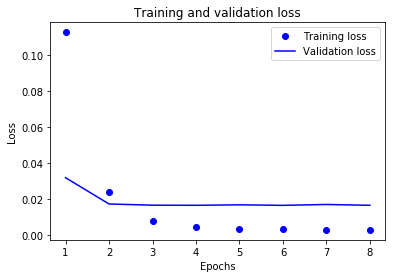

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
predictions1 = model.predict(X_test)
print(predictions1)
Get_score(predictions1, Y_test) # Try remember what the Spearman scores actually mean!


[[0.9031597  0.71853083]
 [0.9641995  0.9676161 ]
 [0.81412476 0.77019316]
 ...
 [0.78117234 0.7391512 ]
 [0.83330584 0.6873788 ]
 [0.8091989  0.6611791 ]]
The Spearman's correlation coefficient is: 0.351
The Spearman's correlation coefficient is: 0.126




# Using TFIDF Algorithm

In [0]:
tfidf=TfidfVectorizer(min_df=1, stop_words='english')

In [0]:
X_TF=tfidf.fit_transform(df['caption'])

In [32]:
X_tfarrseq=X_TF.toarray()
X_tfarrseq

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
print(X_tfarrseq[0])

[0. 0. 0. ... 0. 0. 0.]


In [0]:
Y=df[['short-term_memorability','long-term_memorability']].values  #targets
X=X_tfarrseq #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

In [36]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 5123)
X_test (1200, 5123)
Y_train (4800, 2)
Y_test (1200, 2)


In [37]:
n_cols = X_train.shape[1]
n_cols

5123

In [0]:
# Save the number of columns in predictors: n_cols


# Set up the model: model
model = Sequential()
# Add the first layer
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
# Add the second layer
model.add(Dense(32, activation='relu'))
# Add the output layer
model.add(Dense(2))

In [0]:
# Compile the model
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [40]:
# Verify that model contains information from compiling
print("Loss function: " + model.loss)

Loss function: mean_squared_error


In [41]:
# Fit the model
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 230us/step - loss: 0.1293 - val_loss: 0.0163
Epoch 2/20
4800/4800 [==============================] - 1s 190us/step - loss: 0.0118 - val_loss: 0.0155
Epoch 3/20
4800/4800 [==============================] - 1s 183us/step - loss: 0.0089 - val_loss: 0.0158
Epoch 4/20
4800/4800 [==============================] - 1s 181us/step - loss: 0.0073 - val_loss: 0.0165
Epoch 5/20
4800/4800 [==============================] - 1s 184us/step - loss: 0.0063 - val_loss: 0.0176
Epoch 6/20
4800/4800 [==============================] - 1s 189us/step - loss: 0.0056 - val_loss: 0.0179
Epoch 7/20
4800/4800 [==============================] - 1s 182us/step - loss: 0.0051 - val_loss: 0.0184
Epoch 8/20
4800/4800 [==============================] - 1s 185us/step - loss: 0.0047 - val_loss: 0.0188
Epoch 9/20
4800/4800 [==============================] - 1s 187us/step - loss: 0.0044 - val_loss: 0.0189
Epoch 10/20
4800

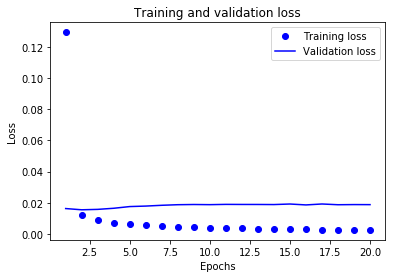

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
predictions2 = model.predict(X_test)
print(predictions2)
Get_score(predictions2, Y_test) # Try remember what the Spearman scores actually mean!

[[0.9145517  0.7995479 ]
 [0.9009045  0.809317  ]
 [0.96128637 0.77456653]
 ...
 [0.9696053  0.97698027]
 [0.8648413  0.7278867 ]
 [0.8588036  0.7203184 ]]
The Spearman's correlation coefficient is: 0.304
The Spearman's correlation coefficient is: 0.161


#MEMORABILITY WITH IMAGE FEATURES

#1. Using HMP Features

#Read HMP Features

In [0]:
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

# Import extracted HMP features

In [0]:
#Load HMP Features
df = pd.DataFrame(columns = ['video', 'arrayInfo'])

#dir_hmp = './dev-set/HMP'
dir_hmp = '/content/drive/My Drive/Semester 2/Machine Learning/Assignment/dev-set/HMP'

for filename in os.listdir(dir_hmp):
    if filename.endswith(".txt"):
        path = os.path.join(dir_hmp, filename)
        array = read_HMP(path)
        fileName= filename.replace(".txt",".webm")
        df = df.append({'video': fileName, 'arrayInfo': array}, ignore_index=True)
    else:
        break

In [46]:
df_hmp = df.merge(labels,on=["video"],how="inner")
df_hmp.columns
df_hmp.head()

,video,arrayInfo,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video6634.webm,"[0.012099, 0.001466, 1.7e-05, 0.0, 0.000683, 7...",0.743,33,0.727,11
1,video6633.webm,"[0.07817, 0.013597, 0.000122, 0.0, 0.00559, 7....",0.804,33,0.727,11
2,video6639.webm,"[0.112506, 0.014053, 0.000263, 0.0, 0.043205, ...",0.645,32,0.800,20
3,video6635.webm,"[0.066072, 0.012682, 0.000283, 0.0, 0.006425, ...",0.806,33,0.923,13
4,video6637.webm,"[0.03036, 0.005834, 0.000169, 0.0, 0.006578, 0...",0.865,34,0.786,14


In [0]:
result_array = np.empty((0, 6075))
for line in df_hmp['arrayInfo']:
    result_array = np.append(result_array, np.array([line]), axis = 0)
  

In [48]:
X_arrHMP = result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.20990e-02, 1.46600e-03, 1.70000e-05, ..., 1.35000e-04,
        1.11000e-04, 7.60000e-05],
       [7.81700e-02, 1.35970e-02, 1.22000e-04, ..., 5.20000e-05,
        8.20000e-05, 6.10000e-05],
       [1.12506e-01, 1.40530e-02, 2.63000e-04, ..., 2.85000e-04,
        5.04000e-04, 1.79000e-04],
       ...,
       [7.80100e-03, 3.51500e-03, 2.65000e-04, ..., 3.20000e-04,
        1.31600e-03, 1.16000e-04],
       [1.27840e-02, 2.92300e-03, 3.20000e-05, ..., 1.56000e-04,
        2.85000e-04, 2.78000e-04],
       [2.95240e-02, 6.14400e-03, 1.69000e-04, ..., 2.43000e-04,
        3.77000e-04, 3.32000e-04]])

In [0]:
Y=df_hmp[['short-term_memorability','long-term_memorability']].values  #targets
X=X_arrHMP #input

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 6075)
X_test (1200, 6075)
Y_train (4800, 2)
Y_test (1200, 2)


In [51]:
n_cols = X_train.shape[1]
n_cols

6075

In [0]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
# Add the second layer
model.add(Dense(100, activation='relu'))
# Add the output layer
model.add(Dense(2))

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [54]:
# Fit the model
#model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))
# Fit the model
history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])


Train on 3360 samples, validate on 1440 samples
Epoch 1/30
3360/3360 [==============================] - 2s 540us/step - loss: 0.1281 - acc: 0.7116 - val_loss: 0.0135 - val_acc: 0.7021
Epoch 2/30
3360/3360 [==============================] - 2s 451us/step - loss: 0.0136 - acc: 0.7131 - val_loss: 0.0132 - val_acc: 0.7021
Epoch 3/30
3360/3360 [==============================] - 2s 453us/step - loss: 0.0135 - acc: 0.7131 - val_loss: 0.0134 - val_acc: 0.7021
Epoch 4/30
3360/3360 [==============================] - 2s 462us/step - loss: 0.0135 - acc: 0.7131 - val_loss: 0.0134 - val_acc: 0.7021


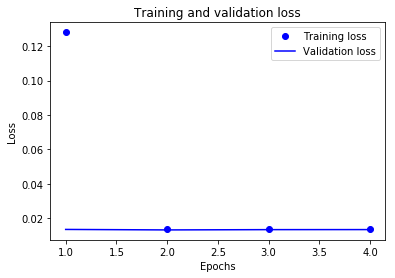

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [100]:
predictions3 = model.predict(X_test)
print(predictions3)
Get_score(predictions3, Y_test) # Try remember what the Spearman scores actually mean!

[[0.85395974 0.7636661 ]
 [0.87125117 0.7775664 ]
 [0.8421284  0.75106066]
 ...
 [0.83525854 0.7475918 ]
 [0.8468822  0.75693995]
 [0.8670186  0.7743375 ]]
The Spearman's correlation coefficient is: 0.285
The Spearman's correlation coefficient is: 0.090


#Creating an ensemble model using simple average method

In [0]:
predictions = np.add(predictions1,predictions3)
#predictions = np.add(predictions,predictions3)

In [107]:
print(predictions)

[[1.7571194 1.4821969]
 [1.8354506 1.7451825]
 [1.6562531 1.5212538]
 ...
 [1.6164309 1.486743 ]
 [1.6801881 1.4443188]
 [1.6762176 1.4355166]]


In [0]:
predictions = np.divide(predictions, 2)

In [109]:
print(predictions)

[[0.8785597  0.74109846]
 [0.9177253  0.87259126]
 [0.82812655 0.7606269 ]
 ...
 [0.80821544 0.7433715 ]
 [0.84009403 0.7221594 ]
 [0.8381088  0.7177583 ]]


In [101]:
print(predictions1)
print(predictions2)
print(predictions3)

[[0.9031597  0.71853083]
 [0.9641995  0.9676161 ]
 [0.81412476 0.77019316]
 ...
 [0.78117234 0.7391512 ]
 [0.83330584 0.6873788 ]
 [0.8091989  0.6611791 ]]
[[0.9145517  0.7995479 ]
 [0.9009045  0.809317  ]
 [0.96128637 0.77456653]
 ...
 [0.9696053  0.97698027]
 [0.8648413  0.7278867 ]
 [0.8588036  0.7203184 ]]
[[0.85395974 0.7636661 ]
 [0.87125117 0.7775664 ]
 [0.8421284  0.75106066]
 ...
 [0.83525854 0.7475918 ]
 [0.8468822  0.75693995]
 [0.8670186  0.7743375 ]]


In [110]:
#pred_out = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

[[0.8785597  0.74109846]
 [0.9177253  0.87259126]
 [0.82812655 0.7606269 ]
 ...
 [0.80821544 0.7433715 ]
 [0.84009403 0.7221594 ]
 [0.8381088  0.7177583 ]]
The Spearman's correlation coefficient is: 0.062
The Spearman's correlation coefficient is: -0.013
